In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

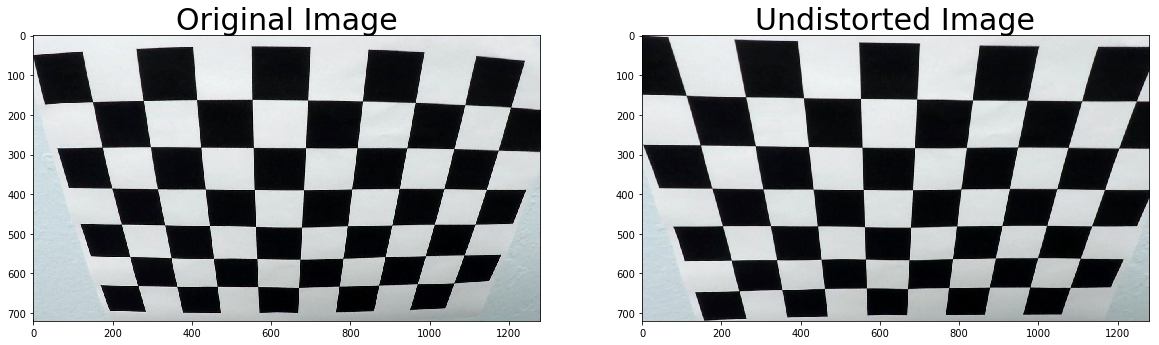

In [2]:
import pickle
#import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Test undistortion on an image
img = cv2.imread('camera_cal/test_image.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/camera_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [80]:
def warper(img, reverse = False):
    src = np.float32(
        [[180, 720],
        [585, 455],
        [695, 455],
        [1100, 720]])
    dst = np.float32(
        [[280, 760],
        [280, 0],
        [1000, 0],
        [1000, 760]])
      
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    if(not reverse):
        warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR)
    else:
        warped = cv2.warpPerspective(img, M_inv, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR)
    return warped, M_inv

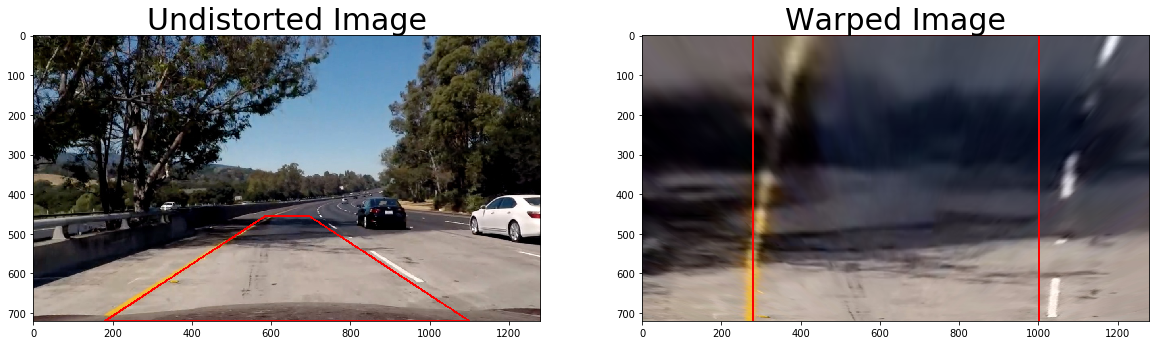

In [83]:
ksize = 3 # Choose a larger odd number to smooth gradient measurements

orig_img = mpimg.imread('test_images/test5.jpg')

undist = cv2.undistort(orig_img, mtx, dist, None, mtx)

cv2.line(undist, (180, 720), (585, 455), (255,0,0), 3)
cv2.line(undist, (585, 455), (695, 455), (255,0,0), 3)
cv2.line(undist, (695, 455), (1100, 720), (255,0,0), 3)
cv2.line(undist, (1100, 720), (180, 720), (255,0,0), 3)

warped, m_inv = warper(cv2.undistort(orig_img, mtx, dist, None, mtx))

cv2.line(warped, (280, 760), (280, 0), (255,0,0), 3)
cv2.line(warped, (280, 0), (1000, 0), (255,0,0), 3)
cv2.line(warped, (1000, 0), (1000, 760), (255,0,0), 3)
cv2.line(warped, (1000, 760), (280, 760), (255,0,0), 3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undist)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Warped Image', fontsize=30)


In [87]:
def abs_sobel_thresh(img, cmap='RGB', orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    # Convert to grayscale
    gray = img
    if cmap == 'RGB':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    return mag_binary

def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def hls_select(img, channel=2, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    color_channel = hls[:,:,channel]
    binary_output = np.zeros_like(color_channel)
    binary_output[(color_channel > thresh[0]) & (color_channel <= thresh[1])] = 1
    return binary_output

def hsv_select(img, channel=1, thresh=(0, 255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    color_channel = hsv[:,:,channel]
    binary_output = np.zeros_like(color_channel)
    binary_output[(color_channel > thresh[0]) & (color_channel <= thresh[1])] = 1
    return binary_output

def combined_threshold_binary(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(40, 255))
    hsv_v_binary = hsv_select(img, 2, thresh=(210, 255))
    gradmag = mag_thresh(img, thresh=(50, 255))
    graddir = dir_thresh(img, thresh=(0.7, 1.3))
    combined_binary = np.zeros_like(hsv_v_binary)
    combined_binary[(hsv_v_binary == 1) | (gradx == 1 | ((gradmag == 1) & (graddir == 1)))]=1
    return combined_binary

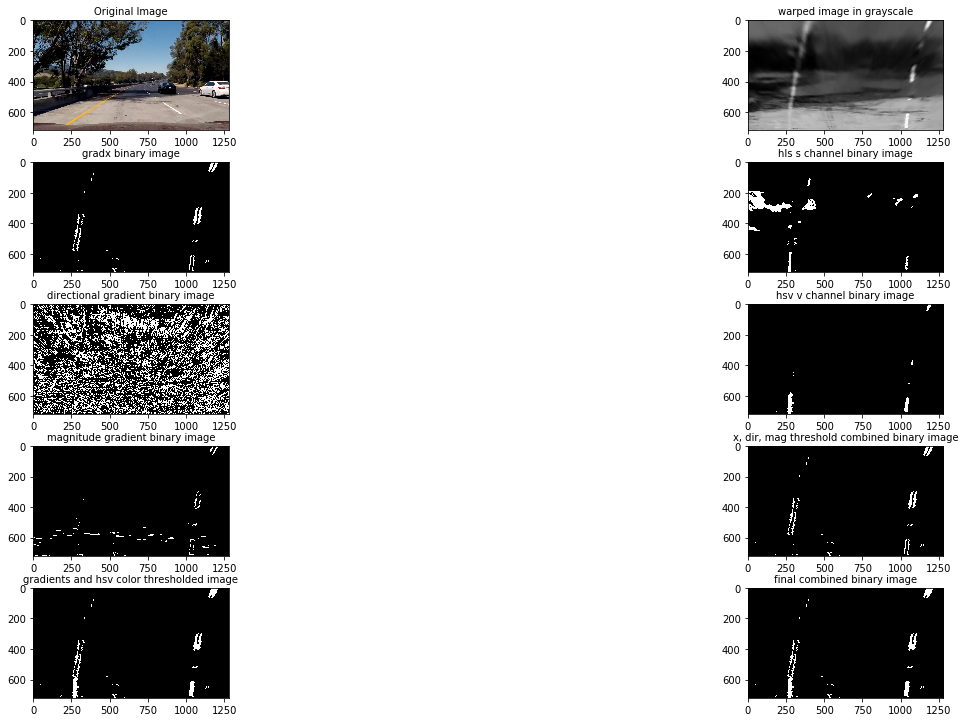

In [86]:
undist = cv2.undistort(orig_img, mtx, dist, None, mtx)
img, m_inv = warper(cv2.undistort(orig_img, mtx, dist, None, mtx))

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(40, 255))

hls_s_binary = hls_select(img, 2, thresh=(170, 255))

hsv_v_binary = hsv_select(img, 2, thresh=(210, 255))

gradmag = mag_thresh(img, thresh=(50, 255))

graddir = dir_thresh(img, thresh=(0.7, 1.3))

combined_binary1 = np.zeros_like(gradx)

combined_binary1[(gradx == 1 | ((gradmag == 1) & (graddir == 1)))] = 1

combined_binary2 = np.zeros_like(hsv_v_binary)

combined_binary2[((hsv_v_binary == 1) | ((gradx == 1 | ((gradmag == 1) & (graddir == 1)))))] = 1

combined_binary_final = combined_threshold_binary(img)

f, ([ax1, ax2], [ax3, ax4], [ax5, ax6], [ax7, ax8], [ax9, ax10]) = plt.subplots(5, 2, figsize=(20,10))
f.tight_layout()
ax1.imshow(orig_img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap='gray')
ax2.set_title('warped image in grayscale', fontsize=10)
ax3.imshow(gradx, cmap='gray')
ax3.set_title('gradx binary image', fontsize=10)

#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
ax4.imshow(hls_s_binary, cmap='gray')
ax4.set_title('hls s channel binary image', fontsize=10)

ax5.imshow(graddir, cmap='gray')
ax5.set_title('directional gradient binary image', fontsize=10)

ax6.imshow(hsv_v_binary, cmap='gray')
ax6.set_title('hsv v channel binary image', fontsize=10)

ax7.imshow(gradmag, cmap='gray')
ax7.set_title('magnitude gradient binary image', fontsize=10)

ax8.imshow(combined_binary1, cmap='gray')
ax8.set_title('x, dir, mag threshold combined binary image', fontsize=10)

ax9.imshow(combined_binary2, cmap='gray')
ax9.set_title('gradients and hsv color thresholded image', fontsize=10)

ax10.imshow(combined_binary_final, cmap='gray')
ax10.set_title('final combined binary image', fontsize=10)

In [88]:
def fit_lines(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #print (leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty, out_img


def continue_fit_lines(binary_warped, left_fit, right_fit):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fit, right_fit, leftx, lefty, rightx, righty

/Users/fengfengtu/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(720, 0)

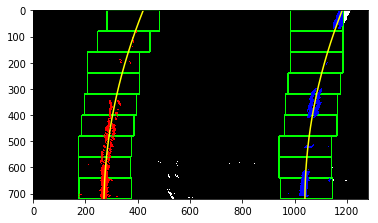

In [89]:
# Generate x and y values for plotting
left_fit, right_fit, leftx, lefty, rightx, righty, out_img = fit_lines(combined_binary_final)

ploty = np.linspace(0, combined_binary_final.shape[0]-1, combined_binary_final.shape[0])

left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[lefty, leftx] = [255, 0, 0] # left line pixels in red
out_img[righty, rightx] = [0, 0, 255] # right line pixels in blue

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

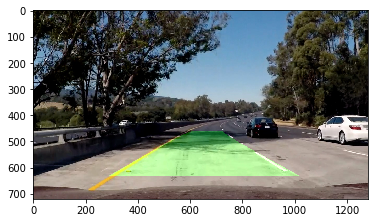

In [92]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(combined_binary_final).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [93]:
def draw_lane_area(orig_img, left_line, right_line, m_inv):
    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(undist).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = np.zeros((720, 1280, 3), dtype='uint8')
    ploty = np.linspace(0, undist.shape[0]-1, undist.shape[0])
    
    left_fit = left_line.get_fit()
    right_fit = right_line.get_fit()
    
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (orig_img.shape[1], orig_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)
    
    # Annotate lane curvature values and vehicle offset from center
    avg_curve = (left_line.get_curvature() + right_line.get_curvature())/2
    label_str = 'Radius of curvature: %.1f m' % avg_curve
    result = cv2.putText(result, label_str, (30,40), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    
    vehicle_offset = left_line.get_vehicle_offset() - right_line.get_vehicle_offset()
    label_str = 'Vehicle offset from lane center: %.1f m' % vehicle_offset
    result = cv2.putText(result, label_str, (30,70), 0, 1, (0,0,0), 2, cv2.LINE_AA)
    
    return result

In [97]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
    def set_curvature(self):
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
        ploty = np.linspace(0, 719, num=720)
        y_eval = 760
        line_fit_cr = np.polyfit(self.ally*ym_per_pix, self.allx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        line_curverad = ((1 + (2*line_fit_cr[0]*y_eval*ym_per_pix + line_fit_cr[1])**2)**1.5) / np.absolute(2*line_fit_cr[0])
        # Now our radius of curvature is in meters
        self.radius_of_curvature = line_curverad
        return line_fit_cr
    def set_line_base_pos(self):
        vehicle_center_x = 1280/2
        y_eval = 720-1
        line_pos_x = self.best_fit[0]*(y_eval**2) + self.best_fit[1]*y_eval + self.best_fit[2]
        vehicle_offset = abs(vehicle_center_x - line_pos_x)

        # Convert pixel offset to meters
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        vehicle_offset *= xm_per_pix
        self.line_base_pos = vehicle_offset
        return vehicle_offset
    def set_current_fit(self, fit, x, y):
        self.diffs = self.current_fit - fit
        self.current_fit = fit
        self.allx = x
        self.ally = y
        self.detected = True
        if self.best_fit is not None:
            self.best_fit = (self.best_fit + fit) / 2
        else:
            self.best_fit = fit
        self.recent_xfitted.append(self.recent_xfitted)
        self.set_line_base_pos()
        self.set_curvature()
        return
    def get_fit(self):
        return self.best_fit
    def get_allx(self):
        return self.allx
    def get_curvature(self):
        return self.radius_of_curvature
    def get_vehicle_offset(self):
        return self.line_base_pos

In [98]:
left_line = Line()
right_line = Line()
detected = False  # did the fast line fit detect the lines?

pickle_file = 'camera_cal/camera_dist_pickle.p'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    mtx = pickle_data['mtx']
    dist = pickle_data['dist']
    del pickle_data
    
def process_image(orig_img):

    global mtx, dist, left_line, right_line, detected, num_detected, num_not_detected
    
    undist = cv2.undistort(orig_img, mtx, dist, None, mtx)
    
    warped, m_inv = warper(undist)
    
    binary_warped  = combined_threshold_binary(warped)

    if not detected:
        left_fit, right_fit, leftx, lefty, rightx, righty, out_img = fit_lines(binary_warped)       
        left_line.set_current_fit(left_fit, leftx, lefty)     
        right_line.set_current_fit(right_fit, rightx, righty)
        detected = True  # slow line fit always detects the line
        
    else: 
        # Continue from the last line fit
        previous_left_fit = left_line.get_fit()
        previous_right_fit = right_line.get_fit()
        left_fit, right_fit, leftx, lefty, rightx, righty = continue_fit_lines(binary_warped, previous_left_fit, previous_right_fit)

        if (left_fit is not None) and (right_fit is not None):          
            left_line.set_current_fit(left_fit, leftx, lefty)       
            right_line.set_current_fit(right_fit, rightx, righty)
        else:
            detected = False

    result = draw_lane_area(orig_img, left_line, right_line, m_inv)

    return result

In [99]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

output_file = 'output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [04:18<00:00,  5.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 4min 18s, sys: 1min 3s, total: 5min 21s
Wall time: 4min 19s


In [100]:
output_file = 'output_challenge.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video output_challenge.mp4
[MoviePy] Writing video output_challenge.mp4


100%|██████████| 485/485 [01:29<00:00,  5.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_challenge.mp4 

CPU times: user 1min 34s, sys: 19.3 s, total: 1min 53s
Wall time: 1min 30s


In [101]:
output_file = 'output_harder_challenge.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video output_harder_challenge.mp4
[MoviePy] Writing video output_harder_challenge.mp4


100%|█████████▉| 1199/1200 [04:27<00:00,  5.03it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_harder_challenge.mp4 

CPU times: user 4min 23s, sys: 1min 3s, total: 5min 26s
Wall time: 4min 28s
